In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

In [43]:
# dados mapa
df_sph_municipios=gpd.read_file(r'C:\Users\ma_ho\OneDrive\Documentos\teste_descrEVE\PARTE_2\DF_Municipios_2024')
go_sph_municipios=gpd.read_file(r'C:\Users\ma_ho\OneDrive\Documentos\teste_descrEVE\PARTE_2\GO_Municipios_2024')
#dados qualidade ar 
quali= pd.read_csv(r'C:\Users\ma_ho\OneDrive\Documentos\teste_descrEVE\PARTE_2\sisam_2018.csv')


In [44]:
Ano=2018

In [23]:
df_geo_filter=df_sph_municipios[['NM_MUN', 'geometry']].copy()

#----------- FILTRANDO GEOMETRY DA REGIÃO METROPOLITANA------------#

municipiosTabela = ['Padre Bernardo', 'Planaltina', 'Formosa', 'Cocalzinho de Goiás', 'Águas Lindas de Goiás',
'Santo Antônio do Descoberto','Valparaíso de Goiás', 'Luziânia','Cidade Ocidental', 'Cristalina Formosa', 'Novo Gama']

condicao = go_sph_municipios['NM_MUN'].isin(municipiosTabela)

go_geometry = go_sph_municipios.loc[condicao, ['NM_MUN', 'geometry']].copy()

#MAPA BASE
go_df_geometry=pd.concat([go_geometry, df_geo_filter], ignore_index=True)

In [24]:
#Pegando dados FOCOS DE CALOR - SATREF
df_focos=pd.read_csv(r'C:\Users\ma_ho\OneDrive\Documentos\teste_descrEVE\PARTE_2\bdq_2019_DF.csv')
go_focos=pd.read_csv(r'C:\Users\ma_ho\OneDrive\Documentos\teste_descrEVE\PARTE_2\bdq_2019_GO.csv')
#Pegando dados FOCOS DE CALOR - TODOS SAT
focosTodos=pd.read_csv(r'C:\Users\ma_ho\OneDrive\Documentos\teste_descrEVE\PARTE_2\focos_todos_2019.csv')

geometryPointsTodos=gpd.points_from_xy(focosTodos['longitude'], focosTodos['latitude'])
geometryPointsDF=gpd.points_from_xy(df_focos['Longitude'], df_focos['Latitude'])
geometryPointsGO=gpd.points_from_xy(go_focos['Longitude'], go_focos['Latitude'])

dadosTodos = {
    'DataHora': focosTodos['data_pas'],
    'Municipio': focosTodos['municipio'],
    'FRP': focosTodos['frp'],
    'areai':focosTodos['id_area_industrial'],        
    'geometry': geometryPointsTodos
}

dadosDF = {
    'DataHora': df_focos['DataHora'],
    'Municipio': df_focos['Municipio'],
    'FRP': df_focos['FRP'],
    'geometry': geometryPointsDF
}

dadosGO = {
    'DataHora': go_focos['DataHora'],
    'Municipio': go_focos['Municipio'],
    'FRP': go_focos['FRP'],
    'geometry': geometryPointsGO
}

municipios = [nome.upper() for nome in municipiosTabela]
muniPlus=[municipios, 'BRASÍLIA']

todos_gpd_focos=gpd.GeoDataFrame(dadosTodos, crs="EPSG:4326")

df_gpd_focos=gpd.GeoDataFrame(dadosDF, crs="EPSG:4326")
go_gpd_focos=gpd.GeoDataFrame(dadosGO, crs="EPSG:4326")

condicao = go_gpd_focos['Municipio'].isin(municipios)
condiPlus = focosTodos['municipio'].isin(muniPlus)

go_focos_geometry = go_gpd_focos.loc[condicao, ['DataHora', 'Municipio', 'FRP', 'geometry']].copy()

focos=pd.concat([df_gpd_focos, go_focos_geometry], ignore_index=True)

#todos os satélites
todos_focos = todos_gpd_focos.loc[condiPlus, ['DataHora', 'Municipio', 'FRP', 'areai', 'geometry']].copy()
#retirando áreas idustriais
todos_focos=todos_focos[todos_focos['areai']!=1].copy()

In [29]:
#----------- FRP MÁXIMO POR MUNICÍPIO ------------#
focos_reprojetados = focos.to_crs(go_df_geometry.crs)
# Spatial Join: Transfere dados dos pontos para os polígonos
# Mantém todos os municípios do 'mapa_base' (how='left')
sjoined_gdf = gpd.sjoin(
    go_df_geometry,
    focos_reprojetados,
    how='left',
    predicate='contains',
)

# Group By: Calcula o FRP máximo para cada município
frp_maximo = sjoined_gdf.groupby('NM_MUN')['FRP'].max().reset_index()
frp_maximo = frp_maximo.rename(columns={'FRP': 'max_FRP'})

# Merge: Junta o valor de FRP máximo de volta ao nosso mapa base
mapa_final_com_frp = go_df_geometry.merge(
    frp_maximo,
    on='NM_MUN',
    how='left'
)

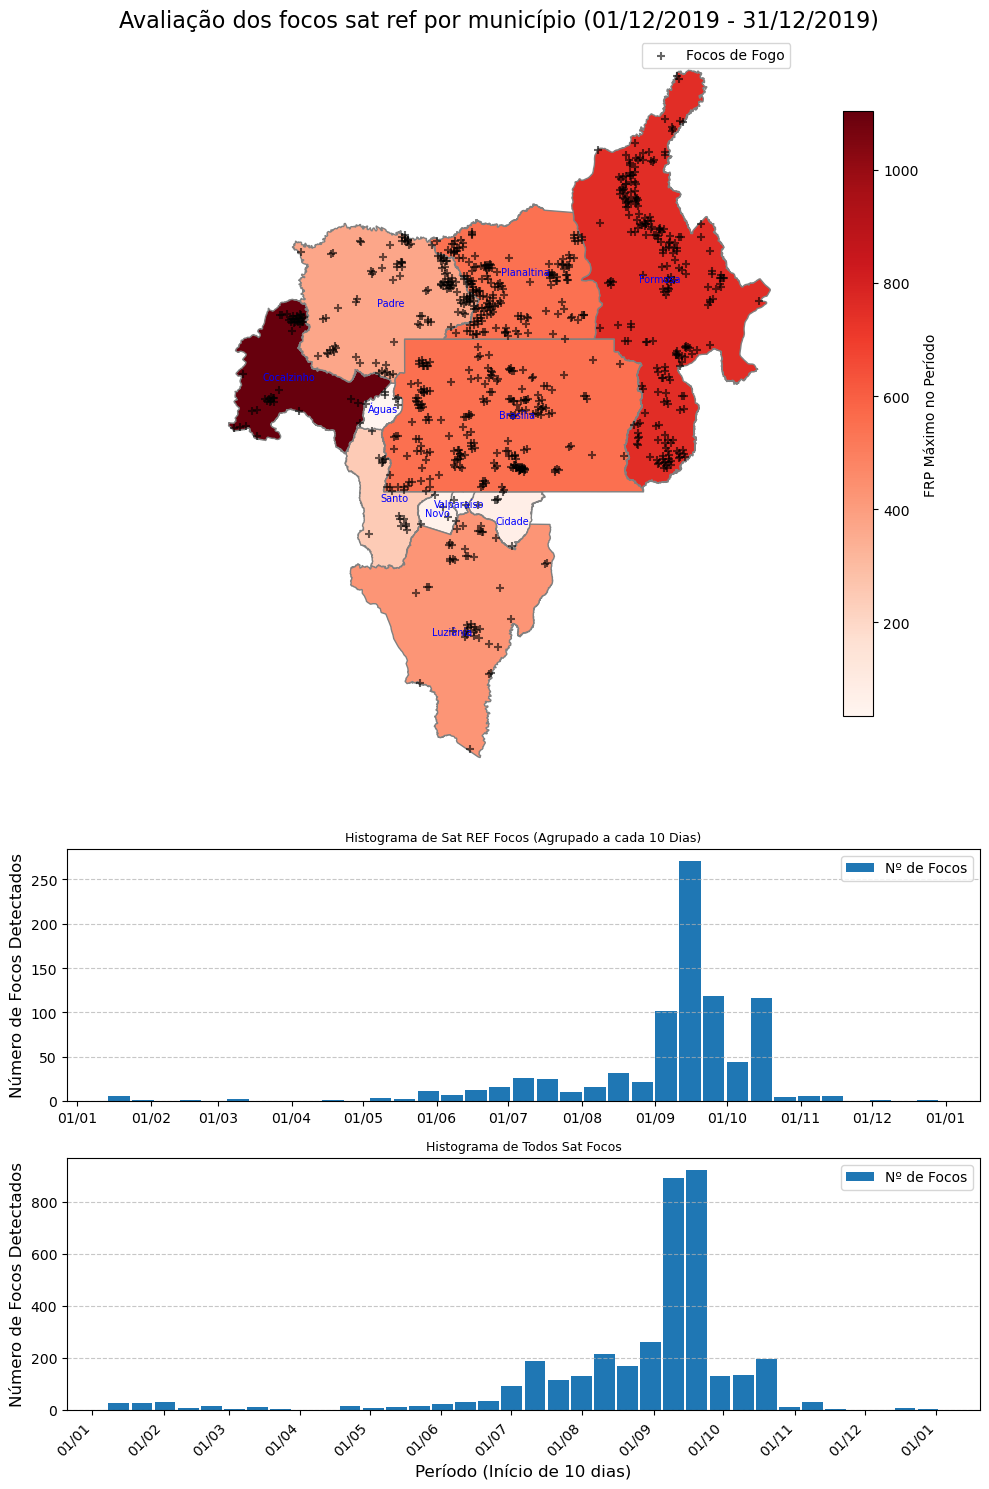

In [31]:
#----------- PLOTAR O Mapa E Histograma FOCOS ------------#
fig, (ax_mapa, ax_hist, ax_hist2) = plt.subplots(
    nrows=3, 
    ncols=1, 
    figsize=(10, 15),
    gridspec_kw={'height_ratios': [3, 1, 1]}
)

# --- O mapa colorido frp max
mapa_final_com_frp.plot(
    ax=ax_mapa,
    column='max_FRP',   
    cmap='Reds',       
    legend=True,
    legend_kwds={'label': "FRP Máximo no Período", 'shrink': 0.8, 'format':"%.0f"},
    # Estilo para municípios SEM focos
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "label": "Sem Focos"},
    edgecolor='gray'
)

focos_reprojetados.plot(ax=ax_mapa, color='black', marker='+', markersize=30, alpha=0.6, label='Focos de Fogo')

# Nomeando estados
for idx, row in mapa_final_com_frp.iterrows():
    ponto = row['geometry'].representative_point()
   
    nome_curto = row['NM_MUN'].split(' ')[0] 
    
    ax_mapa.text(ponto.x, ponto.y, nome_curto, fontsize=7, ha='center', va='center',color='blue')

ax_mapa.set_title(f'Avaliação dos focos sat ref por município (01/12/{Ano} - 31/12/{Ano})', fontsize=16)
ax_mapa.set_axis_off()

#========================== Formatando hora e dia ==========
focos['DataHora'] = pd.to_datetime(focos['DataHora'], errors='coerce')
focos = focos.dropna(subset=['DataHora'])
todos_focos_idx = focos.set_index('DataHora')

contagem_10_dias = todos_focos_idx.resample('10D').size().reset_index(name='contagem_focos')

#========================Mesmo para todos sat

todos_focos['DataHora'] = pd.to_datetime(todos_focos['DataHora'], errors='coerce')
todos_focos = todos_focos.dropna(subset=['DataHora'])
todos_focos2_idx = todos_focos.set_index('DataHora')

contagem_102_dias = todos_focos2_idx.resample('10D').size().reset_index(name='contagem_focos')
    
#============================ Plotar as barras  ============
ax_hist.bar(contagem_10_dias['DataHora'], contagem_10_dias['contagem_focos'], width=9, 
       align='edge', label='Nº de Focos')

ax_hist2.bar(contagem_102_dias['DataHora'], contagem_102_dias['contagem_focos'], width=9, 
       align='edge', label='Nº de Focos')

# Formatar o eixo X mostrar datas legíveis
ax_hist.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=20))
ax_hist.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

ax_hist2.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=20))
ax_hist2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

ax_hist.set_title('Histograma de Sat REF Focos (Agrupado a cada 10 Dias)', fontsize=9)
ax_hist.set_xlabel('', fontsize=12)
ax_hist.set_ylabel('Número de Focos Detectados', fontsize=12)
ax_hist.legend()
ax_hist.grid(axis='y', linestyle='--', alpha=0.7)

ax_hist2.set_title('Histograma de Todos Sat Focos', fontsize=9)
ax_hist2.set_xlabel('Período (Início de 10 dias)', fontsize=12)
ax_hist2.set_ylabel('Número de Focos Detectados', fontsize=12)
ax_hist2.legend()
ax_hist2.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
ax_mapa.legend()

# Salvar a imagem
plt.savefig(f'histograma_e_focos{Ano}.png')
plt.show()


In [32]:
# Qualidade do ar com foco em PM2.5
qualiDFgeometri=gpd.gpd.points_from_xy(quali['longitude'], quali['latitude'])

qDF = {
    'DataHora': quali['datahora'],
    'Municipio': quali['municipio_nome'],
    'pm25': quali['pm25_ugm3'],
    'longitude': quali['longitude'],
    'latitude': quali['latitude'],
    'geometry': qualiDFgeometri
}

qualiDF=gpd.GeoDataFrame(qDF, crs="EPSG:4326")

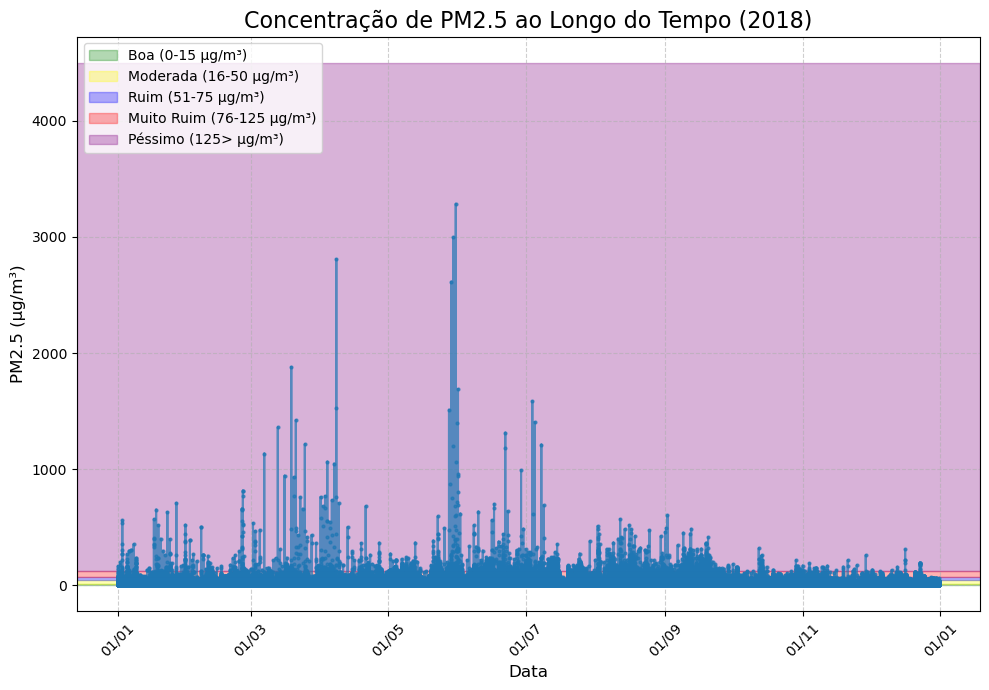

In [45]:
#==================== Converter 'DataHora' -> datetime
qualiDF['DataHora'] = pd.to_datetime(qualiDF['DataHora'], errors='coerce')

qualiDF = qualiDF.dropna(subset=['DataHora', 'pm25'])

# --- O GRÁFICO
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(qualiDF['DataHora'],qualiDF['pm25'],linestyle='-',marker='o',markersize=2,alpha=0.7)

# --- 4. Formatação do Gráfico ---
ax.set_title(f'Concentração de PM2.5 ao Longo do Tempo ({Ano})', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)

#======== Legenda faixas
ax.axhspan(ymin=0,ymax=15,color='green',alpha=0.3, label='Boa (0-15 µg/m³)')
ax.axhspan(ymin=15, ymax=50, color='yellow',alpha=0.3,label='Moderada (16-50 µg/m³)')
ax.axhspan(ymin=50,ymax=75, color='blue',alpha=0.3,label='Ruim (51-75 µg/m³)')
ax.axhspan(ymin=75,ymax=125,color='red',alpha=0.3,label='Muito Ruim (76-125 µg/m³)')
ax.axhspan(ymin=125,ymax=4500, color='purple',alpha=0.3,label='Péssimo (125> µg/m³)')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

#RECORTES TEMPORAIS
#ax.set_ylim(0,500)
#ax.set_xlim(pd.to_datetime(f'{Ano-1}-12'),pd.to_datetime(f'{Ano+1}-02'))

plt.xticks(rotation=45)
ax.grid(True, linestyle='--', alpha=0.6) 
plt.tight_layout() # Ajustar layout

plt.savefig(f'grafico_pm25_temporal_{Ano}.png')
ax.legend(loc='upper left')
plt.show()


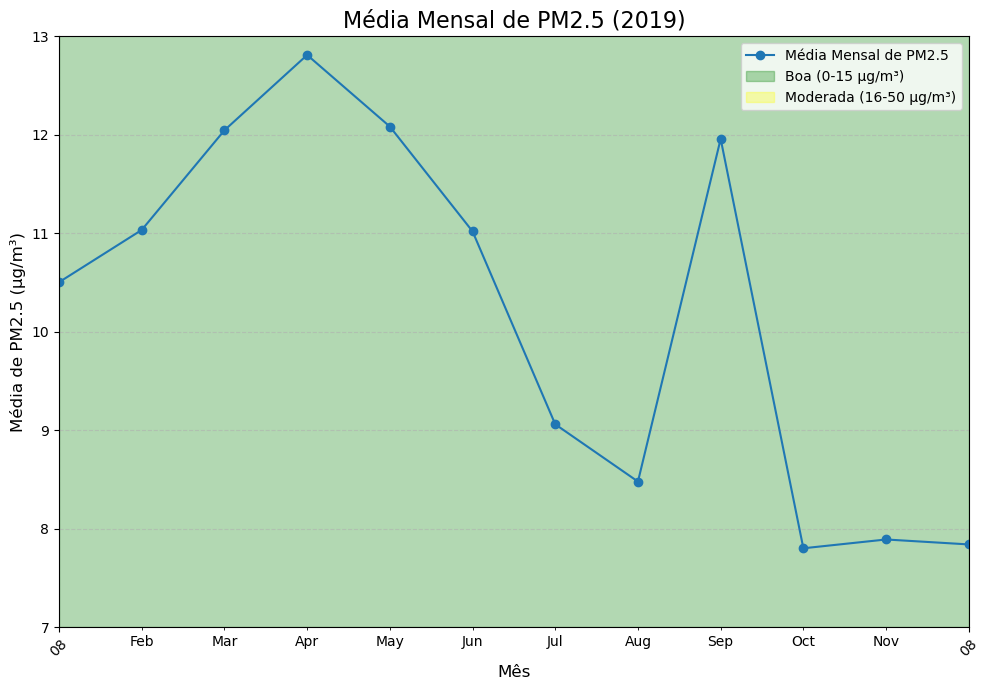

In [35]:
# --- Pensar em média---

if not pd.api.types.is_datetime64_any_dtype(qualiDF['DataHora']):
    qualiDF['DataHora'] = pd.to_datetime(qualiDF['DataHora'], errors='coerce')

# data ser o índice do DataFrame
df_temporal = qualiDF.set_index('DataHora')

# Agrupa os dados em "caixas" mensais e tira a média
media_mensal_pm25 = df_temporal['pm25'].resample('ME').mean()

# =========O Gráfico de Média Mensal

fig, ax = plt.subplots(figsize=(10, 7))

# Plotar o gráfico 
media_mensal_pm25.plot(ax=ax,marker='o', linestyle='-',label='Média Mensal de PM2.5')

# --- 4. Formatação do Gráfico ---
ax.set_title(f'Média Mensal de PM2.5 ({Ano})', fontsize=16)
ax.set_xlabel('Mês', fontsize=12)
ax.set_ylabel('Média de PM2.5 (µg/m³)', fontsize=12)

#======== Legenda faixas
ax.axhspan(ymin=7, ymax=15, color='green', alpha=0.3, label='Boa (0-15 µg/m³)')
ax.axhspan(ymin=15, ymax=20, color='yellow', alpha=0.3,label='Moderada (16-50 µg/m³)')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
# Tentar mostrar um rótulo para cada mês

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

plt.xticks(rotation=45)
ax.legend(loc='upper left')

ax.set_ylim(7,13)
#ax.set_xlim(pd.to_datetime(f'{Ano}-12'), pd.to_datetime(f'{Ano}-01'))

ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()

plt.savefig(f'grafico_pm25_media_mensal_{Ano}.png')
plt.show()